In [ ]:
# Preparing where we were at the end of the last notebook
%matplotlib inline
from htrc_features import FeatureReader
fr = FeatureReader(['data/sample-file1.basic.json.bz2', 'data/sample-file2.basic.json.bz2'])
vol = fr.first()
tokens = vol.tokens_per_page()
tl = vol.tokenlist()

## Working with DataFrames

The Pandas DataFrame type returned by the HTRC Feature Reader is very malleable. To work with the tokenlist that you retrieved earlier, three skills are particularily valuable:

1. Selecting subsets by a condition
2. Slicing by named row index
3. Grouping and aggregating

### Selecting Subsets of a DataFrame by a Condition

Consider this example: *I only want to look at tokens that occur more than a hundred times in the book.* 

Remembering that the table-like output from the HTRC Feature Reader is a Pandas DataFrame, the way to pursue this goal is to learn to filter and subset DataFrames. Knowing how to do so is important for working with just the data that you need.

To subset individual rows of a DataFrame, you can provide a series of True/False values to the DataFrame, formatted in square brackets. When True, the DataFrame returns that row; when False, the row is excluded from what is returned.

To see this in context, first load a basic tokenlist without parts-of-speech or individual pages:

In [ ]:
tl_simple = vol.tokenlist(pos=False, pages=False)
# .sample(5) returns five random words from the full result
tl_simple.sample(5)

count
section token           
body    halleluya      4
        realty         1
        addressed      4
        win-           1
        broke          3

To select just the relevant tokens, we need to look at each row and evaluate whether it matches the criteria that "this token has a count greater than 100". Let's try to convert that requirement to code.

"This token has a count" means that we are concerned specifically with the 'count' column, which can be singled out from the `tl` table with `tl['count']`. "greater than 100" is formalized as `> 100`. Putting it together, try the following and see what you get:

```python
tl_simple['count'] > 100
```

It is a DataFrame of True/False values. Each value indicates whether the 'count' column in the corresponding row matches the criteria or not. We haven't selected a subset yet, we simply asked a question and were told for each row when the question was true or false.

> You may wonder why section and token are still seen, even though 'count' was selected. These are part of the DataFrame **index**, so they're considered part of the information *about* that row rather than data *in* the row. You can convert the index to data columns with `reset_index()`. In this lesson we will keep the index intact, though there are advanced cases where there are benefits to resetting it.

Armed with the True/False values of whether each token's 'count' value is or isn't greater than 100, we can give those values to `tl_simple` in square brackets.

In [ ]:
matches = tl_simple['count'] > 100
tl_simple[matches].sample(5)

count
section token       
body    they     127
        have     210
        The      107
        about    110
        ,       3258

You can move the comparison straight into the square brackets, the more conventional equivalent of the above:

In [ ]:
tl_simple[tl_simple['count'] > 100].sample(5)

count
section token       
body    not      220
        had      455
        have     210
        ,       3258
        his      206

As might be expected, many of the tokens that occur very often are common words like "she" and "and", as well as various punctuation. 

Multiple conditions can be chained with `&` (and) or `|` (or), using regular brackets so that Python knows the order of operations. For example, words with a count greater than 150 *and* a count less than 200 are selected in this way:

In [ ]:
tl_simple[(tl_simple['count'] > 150) & (tl_simple['count'] < 200)]

count
section token       
body    Mr.      159
        be       196
        but      178
        do       179
        is       170
        on       190
        —        167

### Slicing DataFrames

Above, subsets of the DataFrame were selected based on a matching criteria for columns. It is also possible to select a DataFrame subset by specifying the values of its index, a process called **slicing**. For example, you can ask, *"give me all the verbs for pages 9-12"*.

In the DataFrame returned by `vol.tokenlist()`, page, section, token, and POS were part of the index (try the command `tl.index.names` to confirm). One can think of an index as the margin content of an Excel spreadsheet: the letters along the top and numbers along the left side are the indices. A cell can be referred to as A1, A2, B1... In Pandas, however, you can name these, so instead of A, B, C, or 1,2,3, columns and rows can be referred to by more descriptive names. You can also have multiple levels, so you're not bound by the two-dimensions of a table format. With a multi-indexed DataFrame, you can ask for `Page=24,section=Body, ...`.

<img src="images/Excel.PNG" width="300px" alt="One can think of an index as the margin notations in Excel (i.e. 1,2,3... and A,B,C,..), except it can be named and can have multiple levels." />
**Figure: One can think of an index as the margin notations in Excel (i.e. 1,2,3... and A,B,C,..), except it can be named and can have multiple levels.**
    
Slicing a DataFrame against a labelled index is done using `DataFrame.loc[]`. Try the following examples and see what is returned:

- Select information from page 17: 
  - `tl.loc[(17),]`
- Select 'body' section of page 17:
  - `tl.loc[(17, 'body'),]`
- Select counts of the word 'Anne' in the 'body' section of page 17:
  - `tl.loc[(17, 'body', 'Anne'),]`

The levels of the index are specified in order, so in this case the first value refers to 'page', then 'section', and so on. To skip specifying anything for an index level -- that is, to select everything for that level -- `slice(None)` can be used as a placeholder:

- Select counts of the word 'Anne' for all pages and all page sections
  - `tl.loc[(slice(None), slice(None), "Anne"),]`
  
Finally, it is possible to select multiple labels for a level of the index, with a list of labels (i.e. `['label1', 'label2']`) or a sequence covering everything from one value to another (i.e. `slice(start, end)`):

- Select pages 37, 38, and 52
  - `tl.loc[([37, 38, 52]),]`
- Select all pages from 37 to 40
  - `tl.loc[(slice(37, 40)),]`
- Select counts for 'Anne' or 'Hilary' from all pages
  - `tl.loc[(slice(None), slice(None), ["Anne", "Hilary"]),]`
  
> The reason for the comma in `tl.loc[(...),]` is because columns can be selected in the same way after the comma. Pandas DataFrames can have a multiple-level index for columns, but the HTRC Feature Reader does not use this.

Knowing how to slice, let's try to find the word "CHAPTER" in this book, and compare where that shows up to the token-per-page pattern previously plotted.

The token list we previously set to `tl` only included body text; to include headers and footers in a search for `CHAPTER` we'll grab a new tokenlist with `section='all'` specified.

In [ ]:
tl_all = vol.tokenlist(section='all')
chapter_pages = tl_all.loc[(slice(None), slice(None), "CHAPTER"),]
chapter_pages

,,,,count
page,section,token,pos,
19,header,CHAPTER,NNP,1
35,header,CHAPTER,NNP,1
56,header,CHAPTER,NNP,1
73,header,CHAPTER,NNP,1
91,header,CHAPTER,NNP,1
115,header,CHAPTER,NNP,1
141,header,CHAPTER,NNP,1
158,header,CHAPTER,NNP,1
174,header,CHAPTER,NNP,1


Earlier, token counts were visualized using `tokens.plot()`, a built-in function of DataFrames that uses the Matplotlib visualization library. 

We can add to the earlier visualization by using Matplotlib directly. Try the following code in a new cell, which goes through every page number in the earlier search for 'CHAPTER' and adds a red vertical line at the place in the chart with `matplotlib.pyplot.axvline()`:

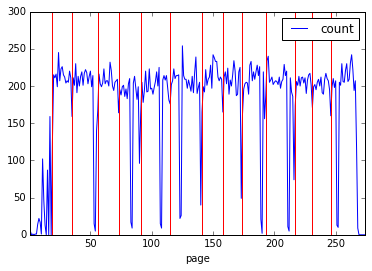

In [ ]:
# Get just the page numbers from the search for "CHAPTER"
page_numbers = chapter_pages.index.get_level_values('page')

# Visualize the tokens-per-page from before
tokens.plot()

# Add vertical lines for pages with "CHAPTER"
import matplotlib.pyplot as plt
for page_number in page_numbers:
    plt.axvline(x=page_number, color='red')

> Advanced: Though slicing with `loc` is more common when working with the index, it is possible to create a True/False list from an index to select rows as we did earlier. Here's an advanced example that grabs the 'token' part of the index and, using the `isalpha()` string method that Pandas provides, filters to fully alphabetical words.
``` 
token_idx = tl.index.get_level_values("token")
tl[token_idx.str.isalpha()]
```
Readers familiar with regular expressions (see [Understanding Regular Expressions](http://programminghistorian.org/lessons/understanding-regular-expressions) by Doug Knox) can adapt this example for even more robust selection using the `contains()` string method.

## Sorting DataFrames

A DataFrame can be sorted with `DataFrame.sort_values()`, specifying the column to sort by as the first argument. By default, sorting is done in ascending order:

In [ ]:
tl_simple.sort_values('count').head()

count
section token             
body    gratified        1
        reminding        1
        dome             1
        remembering      1
        remains          1

Descending order is possible with the argument `ascending=False`, which puts the most common tokens at the top. For example:

In [ ]:
tl_simple.sort_values('count', ascending=False).head()

count
section token       
body    ,       3258
        "       1670
        the     1565
        .       1532
        and     1252

The most common tokens are 'the' and 'and', alongside punctuation.

*Exercise: Try to retrieve the five most-common tokens used as a noun ('NNP') or a plural noun ('NNS') in the book*. You will have to get a new tokenlist, without pages but with parts-of-speech, then slice by the criteria, sort, and output the first five rows. ([Solution](https://gist.github.com/organisciak/163e59ea6cf71c3cd12de410d075567c))

### Grouping DataFrames

Up to this point, the token count DataFrames have been subsetted, but not modified from the way they were returned by the HTRC Feature Reader. There are many cases where one may want to perform aggregation or transformation based on subsets of data. To do this, Pandas supports the 'split-apply-combine' pattern (Wickham 2011).

Split-apply-combine refers to the process of dividing a dataset into groups (*split*), performing some activity for each of those groups (*apply*), and joining the new groups back together into a single DataFrame (*combine*).

<img src="images/split-apply-combine.png" width="500px" alt="Graph demonstrating Split-Apply-Combine." />

<img src="images/example-split-apply-combine.png" width="600px" alt="Example of Split-Apply-Combine, averaging movie grosses by director." />
**Figure: Example of Split-Apply-Combine, averaging movie grosses by director.**

Split-apply-combine processes are supported on DataFrames with `groupby()`, which tells Pandas to split by some criteria. From there, it is possible to apply some change to each group individually, after which Pandas combines the affected groups into a single DataFrame again.

Try the following, can you tell what happens?

```
tl.groupby(level=["pos"]).sum()
```

The output is a count of how often each part-of-speech tag ("pos") occurs in the entire book.

- *Split* with `groupby()`: We took the token count dataframe that is set to `tl` and grouped by the part-of-speech (`pos`) level of the index. This means that rather than thinking in terms of rows, Pandas is now thinking of the `tl` DataFrame as a series of smaller groups, the groups selected by a common value for part of speech. So, all the personal pronouns ("PRP") are in one group, and all the adverbs ("RB") are in another, and so on.
- *Apply* with `sum()`: These groups were sent to an apply function, `sum()`. Sum is an aggregation function, so it sums all the information in the 'count' column for each group. For example, all the rows of data in the adverb group are summed up into a single count of all adverbs. 
- *Combine*: The combine step is implicit: the DataFrame knows from the `groupby` pattern to take everything that the apply function gives back (in the case of 'sum', just one row for every group) and stick it together.

`sum()` is one of many convenient functions [built-in](http://pandas.pydata.org/pandas-docs/stable/groupby.html) to Pandas. Other useful functions are `mean()`, `count()`, `max()`. It is also possible to send your groups to any function that you write with `apply()`.

> groupby can be used on data columns or an index. To run against an index, use `level=[index_level_name]` as above. To group against columns, use `by=[column_name]`.

Below are some examples of grouping token counts.

- Find most common tokens in the entire volume (sorting by most to least occurrences)
  - `tl.groupby(level="token").sum().sort_values("count", ascending=False)`
- Count how many pages each token/pos combination occurs on
  - `tl.groupby(level=["token", "pos"]).count()`
  
Remember from earlier that certain information can be called by sending arguments to `vol.tokenlist()`, so you don't always have to do the grouping yourself.

With `sum`, the data is being reduced: only one row is left for each group. It is also possible to 'transform' a group, where the same number of rows are returned. This is useful if processing is necessary based on the group statistics, such as percentages. Here is an advanced example of transformation, a [TF\*IDF](https://porganized.com/2016/03/09/term-weighting-for-humanists/) function. TF\*IDF weighs a token's value to a document based on how common it is. In this case, it highlights words that are notable for a page but not the entire book.

In [ ]:
from numpy import log
def tfidf(x):
    return x * log(1+vol.page_count / x.count())
# Will take a few seconds to run, depending on your system
idf_scores = tl.groupby(level=["token"]).transform(tfidf)
idf_scores[1000:1100:30]

count
page section token pos          
24   body    years NNS  2.315830
25   body    asked VBD  1.730605
             him   PRP  2.994040
             n't   RB   1.250162

Compare the parts of the function given to `transform()` with the equation:

$ IDF_w = log(1 + \frac{N}{df_w}) $

N is the total number of pages. Document frequency, $df_w$, is 'how many pages (docs) does the word occur on?' That is the `x.count()`. Can you modify the above to use corpus frequency, which is 'how many times does the word occur overall in the corpus (i.e. across all pages)?' You'd want to add everything up.